# **TP de Data visualisation (Maps with folium)**
###réalisé par : DRIEF NISRINE  et ALAE BOUTARHAT

# Analyse des Données sur le Changement Climatique: Température de Surface de la Terre

# **Introduction**
**Objectifs:** Analyser les tendances climatiques historiques dans les grandes villes mondiales en se focalisant sur:

L'évolution temporelle des températures

Les variations saisonnières

Les différences géographiques

**Source des données:** Jeu de données "GlobalLandTemperaturesByMajorCity.csv" de Berkeley Earth disponible sur Kaggle.

# Prétraitement du Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Chargement des données
df = pd.read_csv('/content/drive/MyDrive/DATA VIZ/GlobalLandTemperaturesByMajorCity.csv')

# Affichage des informations de base
print(f"Nombre d'enregistrements: {len(df)}")
print(f"Nombre de colonnes: {len(df.columns)}")
print("\nVariables catégorielles:", df.select_dtypes(include=['object']).columns.tolist())
print("Variables numériques:", df.select_dtypes(include=['float64']).columns.tolist())
print("\nValeurs manquantes:")
print(df.isnull().sum())

Nombre d'enregistrements: 239177
Nombre de colonnes: 7

Variables catégorielles: ['dt', 'City', 'Country', 'Latitude', 'Longitude']
Variables numériques: ['AverageTemperature', 'AverageTemperatureUncertainty']

Valeurs manquantes:
dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64


In [2]:
print(f"Nombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")
print("\nInformations sur le dataframe:")
print(df.info())
print("\nStatistiques descriptives:")
# Remove the unsupported argument datetime_is_numeric
df.describe(include='all')

Nombre de lignes: 239177
Nombre de colonnes: 7

Informations sur le dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB
None

Statistiques descriptives:


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
count,239177,228175.000000,228175.000000,239177,239177,239177,239177
unique,3239,NaN,NaN,100,49,49,93
top,2013-09-01,NaN,NaN,Chicago,India,31.35N,31.38E
freq,100,NaN,NaN,3239,36582,13875,6801
mean,NaN,18.125969,0.969343,NaN,NaN,NaN,NaN
std,NaN,10.024800,0.979644,NaN,NaN,NaN,NaN
min,NaN,-26.772000,0.040000,NaN,NaN,NaN,NaN
25%,NaN,12.710000,0.340000,NaN,NaN,NaN,NaN
50%,NaN,20.428000,0.592000,NaN,NaN,NaN,NaN
75%,NaN,25.918000,1.320000,NaN,NaN,NaN,NaN


In [3]:
# Remplissage par la moyenne mensuelle par ville
df['dt'] = pd.to_datetime(df['dt'])
df['Month'] = df['dt'].dt.month

# Calcul des moyennes mensuelles par ville
monthly_means = df.groupby(['City', 'Month'])['AverageTemperature'].mean().reset_index()
monthly_means.rename(columns={'AverageTemperature': 'MonthlyMean'}, inplace=True)

# Fusion avec le dataframe original
df = pd.merge(df, monthly_means, on=['City', 'Month'], how='left')

# Remplissage des valeurs manquantes
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['MonthlyMean'])
df.drop(columns=['MonthlyMean'], inplace=True)

# Pour les rares cas où la moyenne mensuelle n'existe pas, on utilise la moyenne globale
global_mean = df['AverageTemperature'].mean()
df['AverageTemperature'] = df['AverageTemperature'].fillna(global_mean)

# Même traitement pour l'incertitude
df['AverageTemperatureUncertainty'] = df.groupby(['City', 'Month'])['AverageTemperatureUncertainty'].transform(
    lambda x: x.fillna(x.mean()))
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].fillna(
    df['AverageTemperatureUncertainty'].mean())

In [4]:
# Identification des températures extrêmes
Q1 = df['AverageTemperature'].quantile(0.25)
Q3 = df['AverageTemperature'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df['AverageTemperature'] < lower_bound) | (df['AverageTemperature'] > upper_bound)]
print(f"Nombre de valeurs aberrantes potentielles: {len(outliers)}")

# Nous conservons les valeurs aberrantes car elles pourraient représenter des événements climatiques réels

Nombre de valeurs aberrantes potentielles: 4955


In [5]:
print(f"Nombre de doublons avant nettoyage: {df.duplicated().sum()}")
df = df.drop_duplicates()

Nombre de doublons avant nettoyage: 0


In [6]:
# Conversion de la date en datetime et extraction d'année/mois
df['dt'] = pd.to_datetime(df['dt'])
df['Year'] = df['dt'].dt.year
df['Month'] = df['dt'].dt.month

# Normalisation des noms de villes/pays
df['City'] = df['City'].str.title()
df['Country'] = df['Country'].str.title()

# les Visualisations

In [7]:
from IPython.display import IFrame
documentation = IFrame(src='https://python-visualization.github.io/folium/', width=1000, height=500)
display(documentation)

In [8]:
!pip3 install folium
!pip3 install geocoder
!pip3 install vega_datasets

In [12]:
!pip3 install watermark
import watermark

%load_ext watermark
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [14]:
!pip3 install ipywidgets

In [15]:
!pip install geopy

In [16]:
import folium
import folium.plugins as plugins
import ipywidgets
import geocoder
import geopy
import numpy as np
import pandas as pd
from vega_datasets import data as vds
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.123+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: 

ipywidgets: 7.7.1
folium    : 0.19.5
numpy     : 2.0.2
geopy     : 2.4.1
pandas    : 2.2.2
IPython   : 7.34.0
geocoder  : 1.38.1
matplotlib: 3.10.0
watermark : 2.5.0



# heatMap

In [19]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from tqdm import tqdm

# Chargement des données (tu peux l'adapter selon ton chemin local)
df = pd.read_csv('/content/drive/MyDrive/DATA VIZ/GlobalLandTemperaturesByMajorCity.csv')

# Nettoyage (simplifié ici – tu as déjà fait ça dans le notebook)
df['dt'] = pd.to_datetime(df['dt'])
df['Year'] = df['dt'].dt.year

# Moyenne des températures par ville (sur toute la période)
city_temp = df.groupby('City')['AverageTemperature'].mean().reset_index()

# Initialiser geopy
geolocator = Nominatim(user_agent="heatmap_explorer")
tqdm.pandas()  # pour affichage de progression

# Ajouter coordonnées géographiques
def get_coordinates(city):
    try:
        location = geolocator.geocode(city)
        return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])

city_temp[['lat', 'lon']] = city_temp['City'].progress_apply(get_coordinates)

# Nettoyage des villes sans coordonnées
city_temp = city_temp.dropna(subset=['lat', 'lon'])

# Création des points pour la heatmap [lat, lon, température]
heat_data = [[row['lat'], row['lon'], row['AverageTemperature']] for index, row in city_temp.iterrows()]

# Carte centrée sur le monde
heatmap = folium.Map(location=[20, 0], zoom_start=2, tiles='CartoDB dark_matter')

# Ajout de la heatmap
HeatMap(heat_data, radius=15).add_to(heatmap)

# Affichage
heatmap


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


In [20]:
import pandas as pd
import folium
from folium.plugins import HeatMapWithTime
from geopy.geocoders import Nominatim
from tqdm import tqdm

# Charger les données
df = pd.read_csv('/content/drive/MyDrive/DATA VIZ/GlobalLandTemperaturesByMajorCity.csv')

# Prétraitement
df['dt'] = pd.to_datetime(df['dt'])
df['Year'] = df['dt'].dt.year

# Filtrer pour les années disponibles
df = df[df['Year'] >= 1900]  # facultatif : évite les années avec peu de données

# Calcul de la température moyenne par ville et année
yearly_data = df.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

# Récupérer les coordonnées uniques des villes
geolocator = Nominatim(user_agent="heatmap_time_explorer")
tqdm.pandas()

# Utiliser un dictionnaire pour éviter les appels multiples à Nominatim
city_coords = {}

def get_coordinates(city):
    if city not in city_coords:
        try:
            location = geolocator.geocode(city)
            if location:
                city_coords[city] = (location.latitude, location.longitude)
            else:
                city_coords[city] = (None, None)
        except:
            city_coords[city] = (None, None)
    return pd.Series(city_coords[city])

# Appliquer aux villes uniques
yearly_data[['lat', 'lon']] = yearly_data['City'].progress_apply(get_coordinates)

# Supprimer les villes sans coordonnées
yearly_data = yearly_data.dropna(subset=['lat', 'lon'])

# Organiser les données pour HeatMapWithTime
heatmap_time_data = []
heatmap_time_dates = sorted(yearly_data['Year'].unique().tolist())

for year in heatmap_time_dates:
    year_data = yearly_data[yearly_data['Year'] == year]
    heatmap_time_data.append(
        [[row['lat'], row['lon'], row['AverageTemperature']] for _, row in year_data.iterrows()]
    )

# Création de la carte
map_heatmap_time = folium.Map([39, -98], tiles='CartoDB Dark_Matter', zoom_start=4)

# Plugin HeatMapWithTime
heatmap_time_plugin = HeatMapWithTime(
    heatmap_time_data,
    index=heatmap_time_dates,
    auto_play=True,
    max_opacity=0.8,
    radius=15
)

# Ajout à la carte
heatmap_time_plugin.add_to(map_heatmap_time)

# Affichage
map_heatmap_time


100%|██████████| 11400/11400 [03:06<00:00, 60.99it/s]


In [24]:
import pandas as pd
import folium
import altair as alt
from folium.features import VegaLite

# 1. Charger les données
df = pd.read_csv("/content/drive/MyDrive/DATA VIZ/GlobalLandTemperaturesByMajorCity.csv", parse_dates=["dt"])

# 2. Nettoyage et transformation des coordonnées
def convert_coord(coord):
    try:
        if isinstance(coord, str):
            value = float(coord[:-1])
            return value if coord[-1] in ['N', 'E'] else -value
        return float(coord)
    except:
        return None

df['lat'] = df['Latitude'].apply(convert_coord)
df['lon'] = df['Longitude'].apply(convert_coord)

# 3. Supprimer les lignes manquantes
df = df.dropna(subset=["AverageTemperature", "lat", "lon"])

# 4. Filtrer une ville spécifique
selected_country = "France"
selected_city = "Paris"

city_df = df[(df["Country"] == selected_country) & (df["City"] == selected_city)].copy()

# 5. Créer une colonne 'decade'
city_df["decade"] = (city_df["dt"].dt.year // 10) * 10

# 6. Moyenne par décennie
decade_avg = city_df.groupby("decade")["AverageTemperature"].mean().reset_index()
decade_avg["AverageTemperature"] = decade_avg["AverageTemperature"].round(2)

# 7. Créer un graphique Altair
chart = alt.Chart(decade_avg).mark_bar().encode(
    x=alt.X("decade:O", title="Décennie"),
    y=alt.Y("AverageTemperature:Q", title="Température moyenne (°C)")
).properties(
    width=300,
    height=200,
    title=f"Température Moyenne par Décennie - {selected_city}, {selected_country}"
)

# 8. Créer la carte Folium
m = folium.Map(location=[city_df["lat"].iloc[0], city_df["lon"].iloc[0]], zoom_start=4)

# 9. Ajouter le graphique dans un popup
vega = VegaLite(chart, width="100%", height="100%")
popup = folium.Popup(max_width=500)
vega.add_to(popup)

marker = folium.Marker(
    location=[city_df["lat"].iloc[0], city_df["lon"].iloc[0]],
    tooltip=f"{selected_city}",
)
marker.add_to(m)
popup.add_to(marker)

# 10. Afficher la carte
m

In [25]:
import folium

# Étape 1 : Nettoyage et coordonnées
df['lat'] = df['Latitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'S' else 1))
df['lon'] = df['Longitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'W' else 1))

# Étape 2 : Garder une seule ville par pays
countries_df = df.drop_duplicates(subset=['Country'])

# Étape 3 : Moyenne de température par pays
avg_temp_by_country = df.groupby('Country')['AverageTemperature'].mean().to_dict()

# Étape 4 : Créer la carte
world = folium.Map(zoom_start=2)

# Étape 5 : Ajout des marqueurs avec icônes personnalisées
for _, row in countries_df.iterrows():
    lat, lon = row['lat'], row['lon']
    country = row['Country']
    avg_temp = avg_temp_by_country.get(country, None)

    if avg_temp is None:
        continue

    # Choisir une icône et une couleur selon la température
    if avg_temp < 5:
        icon_name = 'snowflake'
        color = 'blue'
    elif avg_temp < 15:
        icon_name = 'cloud'
        color = 'lightgray'
    else:
        icon_name = 'sun'
        color = 'orange'

    popup_text = f"<b>Pays :</b> {country}<br><b>Température Moyenne :</b> {avg_temp:.2f} °C"

    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_text, max_width=200),
        icon=folium.Icon(color=color, icon=icon_name, prefix='fa')
    ).add_to(world)

world

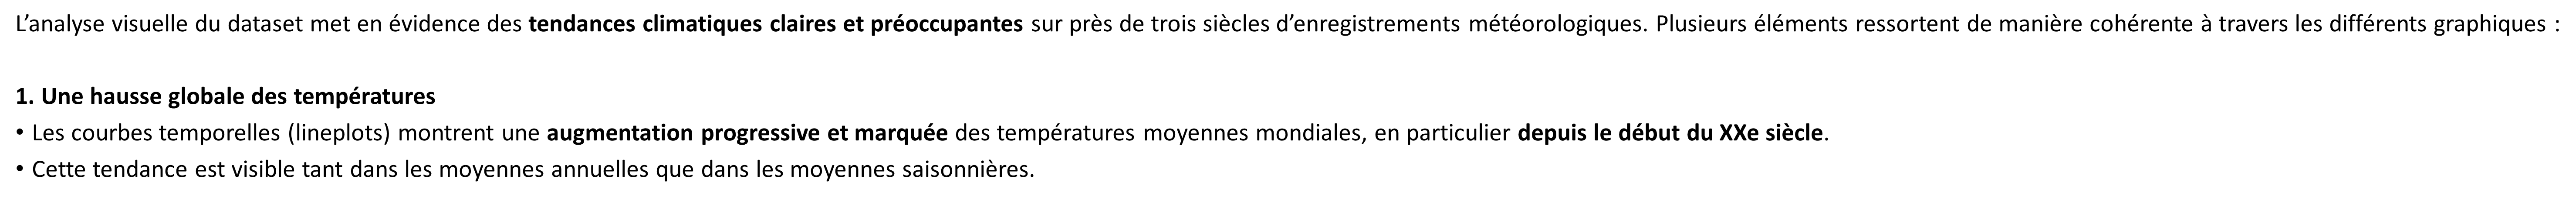
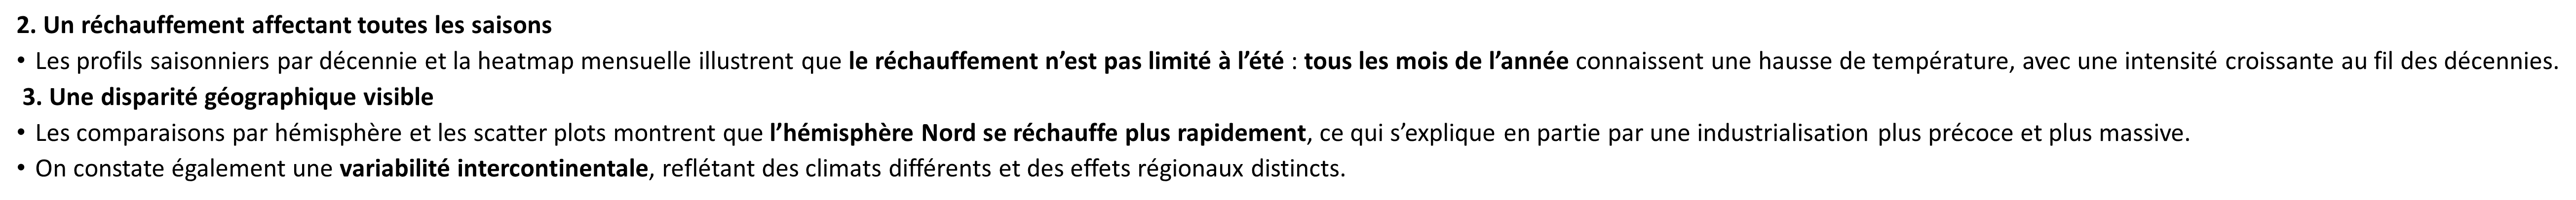